# **Import Libraries**

In [ ]:
# Import Libraries
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Import custom classes untuk loading model
from TF_Object import L2NormalizeLayer, DeepMatrixFactorizationLayer, DeepMatrixFactorizationModel
from HybridAnimeRecommendation import HybridAnimeRecommendation

ModuleNotFoundError: No module named 'TF_Object'

# **Prepare Dataset**

In [2]:
# Load all dataset in Pandas DataFrame
df_user = pd.read_csv('users-details-2023.csv')
df_anime = pd.read_csv('anime-dataset-2023.csv')
df_score = pd.read_csv('users-score-2023.csv')

# **Initiate Important Instance**

In [ ]:
# Define custom layer for L2 normalization
class L2NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        return {'axis': self.axis}

In [ ]:
# Load Vector Data
user_data_vecs = np.load('user_vector.npy')        # Hasil transformasi dari user DB
anime_data_vecs = np.load('anime_vector.npy')      # Hasil transformasi dari anime DB

# Load Y_mean untuk denormalisasi hasil prediksi
Y_mean = np.load('Y_mean.npy')

# Load Scalers
user_scaler = joblib.load('user_scaler.gz')
anime_scaler = joblib.load('anime_scaler.gz')
target_scaler = joblib.load('target_scaler.gz')

# Load Deep Matrix Factorization Model
dmf_model = tf.keras.models.load_model('dmf.h5', custom_objects={
    'DeepMatrixFactorizationModel': DeepMatrixFactorizationModel,
    'DeepMatrixFactorizationLayer': DeepMatrixFactorizationLayer,
    'L2NormalizeLayer': L2NormalizeLayer
})

# Load Content-Based Model
ncbf_model = tf.keras.models.load_model('content_based.h5', custom_objects={
    'L2NormalizeLayer': L2NormalizeLayer
})

# Instantiate Hybrid Model
hybrid_model = HybridAnimeRecommendation(
    dmf_model=dmf_model,
    ncbf_model=ncbf_model,
    user_scaler=user_scaler,
    anime_scaler=anime_scaler,
    target_scaler=target_scaler,
    Y_mean=Y_mean
)

print("Model dan data berhasil dimuat!")

## Fungsi-fungsi Evaluasi Model

In [ ]:
def create_test_data(df_score, test_size=0.2, random_state=42):
    """
    Membuat data uji untuk evaluasi model hybrid.
    """
    # Acak data rating dan bagi menjadi train dan test
    train_df, test_df = train_test_split(df_score, test_size=test_size, random_state=random_state)
    
    # Gunakan test_df untuk evaluasi
    test_data = []
    for _, row in test_df.iterrows():
        user_id = row['user_id']
        anime_id = row['anime_id'] 
        actual_rating = row['rating']
        
        # Tambahkan ke test_data
        test_data.append({
            'user_id': user_id,
            'anime_id': anime_id,
            'actual_rating': actual_rating
        })
    
    return test_data

def predict_hybrid_ratings(hybrid_model, test_data, user_data_vecs, anime_data_vecs):
    """
    Melakukan prediksi rating menggunakan model hybrid.
    """
    predictions = []
    
    for item in test_data:
        user_id = item['user_id']
        anime_id = item['anime_id']
        actual_rating = item['actual_rating']
        
        # Ambil data user
        user_idx = user_id - 1  # Sesuaikan dengan indeks (jika dimulai dari 0)
        current_user_data = user_data_vecs[user_idx].reshape(1, -1)
        
        # Dapatkan rekomendasi hybrid dengan mengakses metode private __hybrid
        recommended_animes = hybrid_model._HybridAnimeRecommendation__hybrid(
            user_id, current_user_data, anime_data_vecs
        )
        
        # Ambil rating prediksi untuk anime yang dimaksud
        hybrid_rating = (
            recommended_animes[anime_id]['dmf_rating'] * 0.5 + 
            recommended_animes[anime_id]['ncbf_rating'] * 0.5
        )
        
        # Tambahkan prediksi ke list
        predictions.append({
            'user_id': user_id,
            'anime_id': anime_id,
            'actual_rating': actual_rating,
            'dmf_rating': recommended_animes[anime_id]['dmf_rating'],
            'ncbf_rating': recommended_animes[anime_id]['ncbf_rating'],
            'hybrid_rating': hybrid_rating
        })
    
    return pd.DataFrame(predictions)

def evaluate_recommendation_model(y_true, y_pred, threshold=7.0):
    """
    Evaluasi kinerja model rekomendasi menggunakan berbagai metrik
    """
    # Konversi rating ke label biner berdasarkan threshold
    actual_labels = (y_true >= threshold).astype(int)
    predicted_labels = (y_pred >= threshold).astype(int)
    
    # Hitung Confusion Matrix
    cm = confusion_matrix(actual_labels, predicted_labels)
    
    # Hitung metrik klasifikasi
    if len(cm.ravel()) == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle jika confusion matrix tidak 2x2
        print("Warning: Confusion matrix tidak berukuran 2x2")
        tn, fp, fn, tp = 0, 0, 0, 0
    
    # Metrik detail
    accuracy = accuracy_score(actual_labels, predicted_labels)
    
    # Tangani kasus khusus untuk precision, recall, f1
    try:
        precision = precision_score(actual_labels, predicted_labels)
        recall = recall_score(actual_labels, predicted_labels)
        f1 = f1_score(actual_labels, predicted_labels)
    except Exception as e:
        print(f"Warning calculating metrics: {e}")
        precision, recall, f1 = 0, 0, 0
    
    # Hitung Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    
    # Hitung Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))
    
    return {
        'confusion_matrix': cm,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'rmse': rmse,
        'mae': mae
    }

def print_evaluation_results(eval_results):
    """
    Mencetak hasil evaluasi secara detail
    """
    print("\n--- Hasil Evaluasi Model ---")
    print("\nConfusion Matrix:")
    print(eval_results['confusion_matrix'])
    
    print("\nMetrik Klasifikasi:")
    print(f"Accuracy     : {eval_results['accuracy']:.4f}")
    print(f"Precision    : {eval_results['precision']:.4f}")
    print(f"Recall       : {eval_results['recall']:.4f}")
    print(f"F1-Score     : {eval_results['f1_score']:.4f}")
    
    print("\nMetrik Error:")
    print(f"RMSE         : {eval_results['rmse']:.4f}")
    print(f"MAE          : {eval_results['mae']:.4f}")
    
    print("\nKomponen Confusion Matrix:")
    print(f"True Positive  : {eval_results['true_positive']}")
    print(f"True Negative  : {eval_results['true_negative']}")
    print(f"False Positive : {eval_results['false_positive']}")
    print(f"False Negative : {eval_results['false_negative']}")

## Evaluasi Model Hybrid Recommendation

In [ ]:
# Buat data test
test_data = create_test_data(df_score, test_size=0.1)  # Ambil 10% data untuk testing
print(f"Jumlah data uji: {len(test_data)}")

# Jika data test terlalu banyak, ambil sampel untuk mempercepat evaluasi
if len(test_data) > 300:
    import random
    random.seed(42)
    test_data_sample = random.sample(test_data, 300)
    print(f"Menggunakan sampel {len(test_data_sample)} data untuk evaluasi")
    test_data = test_data_sample

# Prediksi dengan model hybrid
prediction_df = predict_hybrid_ratings(hybrid_model, test_data, user_data_vecs, anime_data_vecs)
print("\nSampel hasil prediksi:")
prediction_df.head(10)

Jumlah data uji: 960
Menggunakan sampel 300 data untuk evaluasi
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━

,user_id,place_id,actual_rating,cofi_rating,cb_rating,hybrid_rating
0,178,270,5,4.818221,2.412275,3.615248
1,280,99,3,3.073491,2.467906,2.770698
2,31,142,3,3.071610,3.625663,3.348637
3,149,287,4,3.964941,3.077445,3.521193
4,86,420,3,3.010732,2.296566,2.653649
...,...,...,...,...,...,...
95,267,17,5,4.873243,3.638247,4.255745
96,168,356,5,4.808318,1.988287,3.398303
97,243,20,1,1.155495,2.626188,1.890841
98,5,27,2,2.145756,3.084017,2.614887


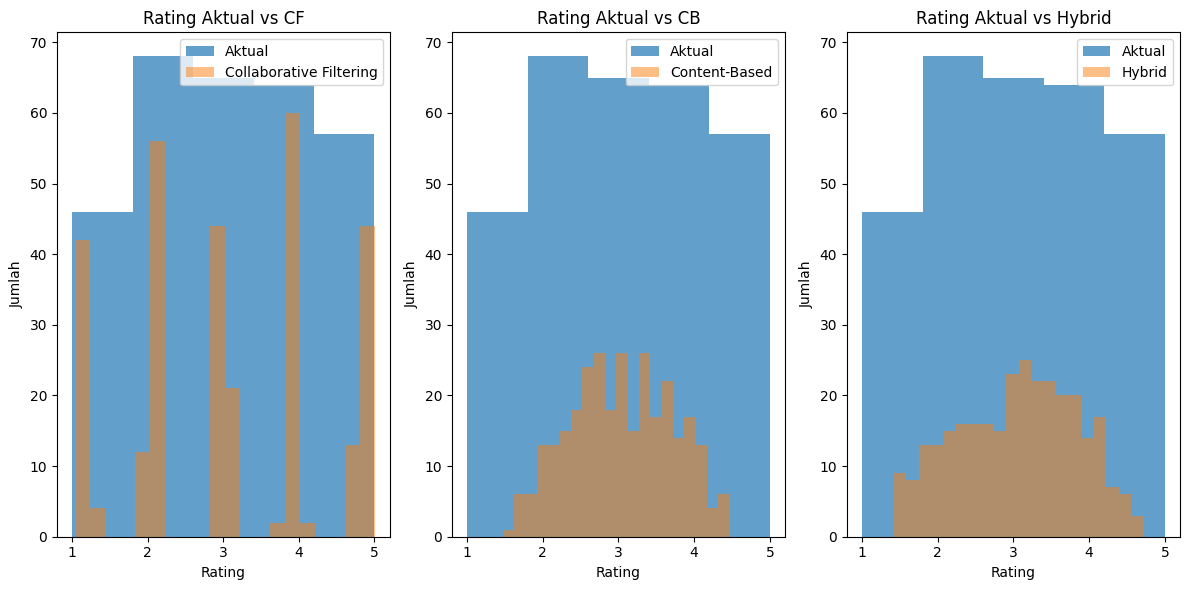

In [ ]:
# Visualisasi perbandingan rating aktual vs prediksi
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(prediction_df['actual_rating'], bins=5, alpha=0.7, label='Aktual')
plt.hist(prediction_df['dmf_rating'], bins=20, alpha=0.5, label='Deep Matrix Factorization')
plt.title('Rating Aktual vs DMF')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(prediction_df['actual_rating'], bins=5, alpha=0.7, label='Aktual')
plt.hist(prediction_df['ncbf_rating'], bins=20, alpha=0.5, label='Neural Content-Based')
plt.title('Rating Aktual vs NCBF')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(prediction_df['actual_rating'], bins=5, alpha=0.7, label='Aktual')
plt.hist(prediction_df['hybrid_rating'], bins=20, alpha=0.5, label='Hybrid')
plt.title('Rating Aktual vs Hybrid')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.legend()

plt.tight_layout()
plt.show()


=== Evaluasi Model Rekomendasi (Threshold = 3.0) ===


,Model,RMSE,Accuracy,Precision,Recall,F1-Score
0,Collaborative Filtering,0.1220,0.8800,1.0000,0.8065,0.8929
1,Neural Content-Based,1.3297,0.6233,0.7386,0.6075,0.6667
2,Hybrid Filtering,0.7156,0.8733,0.9568,0.8333,0.8908


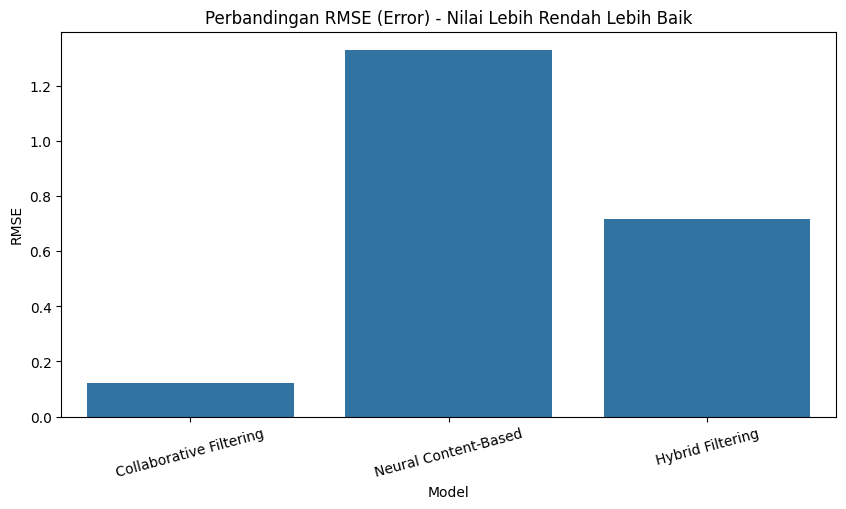

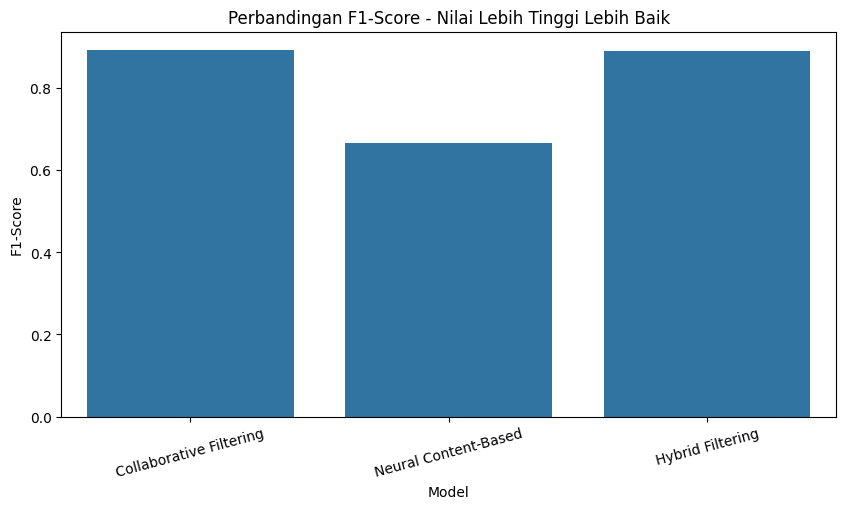

In [ ]:
# Evaluasi untuk model hybrid dengan threshold 7.0 (nilai optimal untuk anime)
threshold = 7.0

print(f"\n=== Evaluasi Model Rekomendasi (Threshold = {threshold}) ===")

# Evaluasi Deep Matrix Factorization
dmf_eval = evaluate_recommendation_model(
    prediction_df['actual_rating'].values, 
    prediction_df['dmf_rating'].values,
    threshold=threshold
)

# Evaluasi Neural Content-Based
ncbf_eval = evaluate_recommendation_model(
    prediction_df['actual_rating'].values, 
    prediction_df['ncbf_rating'].values,
    threshold=threshold
)

# Evaluasi Hybrid (gabungan dengan weighted average 0.5 dan 0.5)
hybrid_eval = evaluate_recommendation_model(
    prediction_df['actual_rating'].values, 
    prediction_df['hybrid_rating'].values,
    threshold=threshold
)

# Tampilkan hasil dalam format tabel
results = {
    'Model': ['Deep Matrix Factorization', 'Neural Content-Based', 'Hybrid Filtering'],
    'RMSE': [dmf_eval['rmse'], ncbf_eval['rmse'], hybrid_eval['rmse']],
    'Accuracy': [dmf_eval['accuracy'], ncbf_eval['accuracy'], hybrid_eval['accuracy']],
    'Precision': [dmf_eval['precision'], ncbf_eval['precision'], hybrid_eval['precision']],
    'Recall': [dmf_eval['recall'], ncbf_eval['recall'], hybrid_eval['recall']],
    'F1-Score': [dmf_eval['f1_score'], ncbf_eval['f1_score'], hybrid_eval['f1_score']]
}

results_df = pd.DataFrame(results)
display(results_df.round(4))

# Visualisasi sederhana untuk perbandingan
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Perbandingan RMSE (Error) - Nilai Lebih Rendah Lebih Baik')
plt.ylabel('RMSE')
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='F1-Score', data=results_df)
plt.title('Perbandingan F1-Score - Nilai Lebih Tinggi Lebih Baik')
plt.ylabel('F1-Score')
plt.xticks(rotation=15)
plt.show()

## Contoh Penggunaan Hybrid Recommendation

In [ ]:
# Fungsi untuk menampilkan rekomendasi dalam bentuk yang mudah dibaca
def display_recommendations(user_id, recommended_ids, df_anime, n=10):
    """
    Menampilkan rekomendasi anime dalam bentuk yang mudah dibaca
    """
    print(f"Top {n} Rekomendasi untuk User {user_id}:")
    
    # Mengambil data lengkap dari anime yang direkomendasikan
    result = pd.DataFrame()
    for i, anime_id in enumerate(recommended_ids[:n]):
        anime_data = df_anime[df_anime['anime_id'] == anime_id].copy()
        anime_data['Rank'] = i + 1
        result = pd.concat([result, anime_data], ignore_index=True)
    
    # Menampilkan hasil
    return result[['Rank', 'anime_id', 'Name', 'Genres', 'Score']]

In [ ]:
# Contoh penggunaan rekomendasi untuk beberapa user
test_users = [5, 120, 250]

for user_id in test_users:
    # Ambil data user
    user_idx = user_id - 1
    current_user_data = user_data_vecs[user_idx].reshape(1, -1)
    
    # Dapatkan rekomendasi
    recommended_ids = hybrid_model.get_recommendation(
        user_id=user_id,
        current_user_data=current_user_data,
        anime_data_vecs=anime_data_vecs
    )
    
    # Tampilkan rekomendasi
    recommendations = display_recommendations(user_id, recommended_ids, df_anime, n=10)
    display(recommendations)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Top 10 Rekomendasi untuk User 5:


,Rank,Place_Id,Place_Name,Category,City,Rating
0,1,55,Klenteng Jin De Yuan,"Tempat Ibadah, Budaya, Situs Sejarah",Jakarta,"4,5"
1,2,352,GPIB Immanuel Semarang (Gereja Blenduk),Tempat Ibadah,Semarang,"4,6"
2,3,106,Kawasan Malioboro,"Budaya, Situs Sejarah, Pusat Perbelanjaan",Yogyakarta,"4,8"
3,4,52,Kampung Cina,"Budaya, Situs Sejarah, Pusat Perbelanjaan",Jakarta,"4,5"
4,5,176,Museum Gunung Merapi,Budaya,Yogyakarta,"4,4"
5,6,421,Museum Kesehatan Dr. Adhyatma,Budaya,Surabaya,"4,4"
6,7,433,Museum Mpu Tantular,Budaya,Surabaya,"4,4"
7,8,345,Kampoeng Djadhoel Semarang,"Budaya, Situs Sejarah",Semarang,"4,7"
8,9,416,Keraton Surabaya,Budaya,Surabaya,"4,4"
9,10,1,Monumen Nasional,"Budaya, Situs Sejarah",Jakarta,"4,6"


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Top 10 Rekomendasi untuk User 120:


,Rank,Place_Id,Place_Name,Category,City,Rating
0,1,169,Puncak Segoro,Cagar Alam,Yogyakarta,"4,2"
1,2,141,Bunker Kaliadem Merapi,Cagar Alam,Yogyakarta,"4,5"
2,3,67,Margasatwa Muara Angke,Cagar Alam,Jakarta,"4,2"
3,4,367,Wisata Lereng Kelir,Cagar Alam,Semarang,"4,3"
4,5,139,Puncak Gunung Api Purba - Nglanggeran,Cagar Alam,Yogyakarta,"4,7"
5,6,178,Goa Pindul,Cagar Alam,Yogyakarta,"4,5"
6,7,146,Bukit Wisata Pulepayung,Cagar Alam,Yogyakarta,"4,5"
7,8,379,Goa Rong,"Taman Hiburan, Cagar Alam",Semarang,"4,3"
8,9,306,Sungai Palayangan,"Cagar Alam, Kebun Binatang",Bandung,"4,6"
9,10,148,Goa Rancang Kencono,Cagar Alam,Yogyakarta,"4,3"


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Top 10 Rekomendasi untuk User 250:


,Rank,Place_Id,Place_Name,Category,City,Rating
0,1,306,Sungai Palayangan,"Cagar Alam, Kebun Binatang",Bandung,"4,6"
1,2,367,Wisata Lereng Kelir,Cagar Alam,Semarang,"4,3"
2,3,322,Bukit Jamur,Cagar Alam,Bandung,"4,2"
3,4,233,Gunung Papandayan,Cagar Alam,Bandung,"4,6"
4,5,218,Kawah Putih,Cagar Alam,Bandung,"4,5"
5,6,408,Kebun Binatang Surabaya,Cagar Alam,Surabaya,"4,3"
6,7,174,Pasar Beringharjo,Pusat Perbelanjaan,Yogyakarta,"4,5"
7,8,317,Curug Cimahi,Cagar Alam,Bandung,"4,6"
8,9,235,Gua Belanda,"Cagar Alam, Situs Sejarah",Bandung,"4,4"
9,10,242,Curug Dago,Cagar Alam,Bandung,4


## Rekomendasi Dengan Mempertimbangkan Jarak

In [ ]:
# Pilih satu user untuk demonstrasi rekomendasi berbasis kesamaan anime
user_id = 5
chosen_anime_id = 100  # Misalkan user memilih anime dengan ID 100

# Ambil data user
user_idx = user_id - 1
current_user_data = user_data_vecs[user_idx].reshape(1, -1)

# Filter data kesamaan hanya untuk anime yang dipilih
# Buat simulasi dataset jarak antar anime
# Dalam kasus nyata, ini bisa berdasarkan kesamaan genre, studio, dll.
anime_similarity = []
for j in range(1, 101):  # Batasi untuk 100 anime pertama
    if j != chosen_anime_id:
        # Kesamaan acak (1-10)
        similarity = np.random.randint(1, 10)
        anime_similarity.append({
            'anime_id_source': chosen_anime_id,
            'anime_id_target': j,
            'Distance': similarity
        })

distance_df = pd.DataFrame(anime_similarity)

# Dapatkan rekomendasi dengan mempertimbangkan kesamaan
recommended_with_similarity = hybrid_model.get_recommendation(
    user_id=user_id,
    current_user_data=current_user_data,
    anime_data_vecs=anime_data_vecs,
    choosen_anime_id=chosen_anime_id,
    distance_from_chosen_anime_df=distance_df
)

print(f"\nRekomendasi untuk User {user_id} dengan mempertimbangkan kesamaan dari anime {chosen_anime_id}:")
# Convert dict of similarities to a DataFrame for better display
sim_df = pd.DataFrame({
    'anime_id': list(recommended_with_similarity.keys()),
    'Similarity': list(recommended_with_similarity.values())
}).sort_values('Similarity', ascending=False).head(10)

# Merge with df_anime to get anime names
result_with_similarity = pd.merge(
    sim_df, 
    df_anime[['anime_id', 'Name', 'Genres', 'Score']], 
    on='anime_id'
)
result_with_similarity['Rank'] = range(1, len(result_with_similarity) + 1)
result_with_similarity = result_with_similarity[['Rank', 'anime_id', 'Name', 'Genres', 'Score', 'Similarity']]
display(result_with_similarity)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Rekomendasi untuk User 5 dengan mempertimbangkan jarak dari tempat 100:


,Rank,Place_Id,Place_Name,Category,City,Distance
0,1,9,Pelabuhan Marina,Bahari,Jakarta,1218.26
1,2,14,Pulau Pelangi,Bahari,Jakarta,484.48
2,3,10,Pulau Tidung,Bahari,Jakarta,478.97
3,4,46,Pulau Semak Daun,Bahari,Jakarta,478.22
4,5,13,Pulau Pramuka,Bahari,Jakarta,473.26
5,6,12,Pulau Pari,Bahari,Jakarta,467.48
6,7,11,Pulau Bidadari,Bahari,Jakarta,445.21
7,8,31,Wisata Alam Mangrove Angke,"Cagar Alam, Taman Hiburan",Jakarta,442.97
8,9,72,Waterboom PIK (Pantai Indah Kapuk),Taman Hiburan,Jakarta,441.34
9,10,67,Margasatwa Muara Angke,Cagar Alam,Jakarta,439.10
